In [1]:
! pip install transformers datasets torch-summary

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, ClassLabel, concatenate_datasets

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
df = pd.read_csv('/content/drive/MyDrive/finalCSV.V0.7.csv',
                 names=['index', 'claim', 'response', 'label'],
                 header=None,
                 skiprows=1,
                 quotechar='"',
                 escapechar='\\')


In [17]:
df = df.dropna()

In [18]:
class_names = ['Supported', 'Refuted', 'Conflicting Evidence/Cherrypicking', 'Not Enough Evidence']
class_label = ClassLabel(names=class_names)
df['label'] = df['label'].apply(lambda x: class_label.str2int(x))

In [19]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(
    model_name,
    use_fast=True,  # Important for Kaggle compatibility
    force_download=True  # Ensure fresh download
)

def tokenize_function(examples):
    return tokenizer(
        examples['claim'],
        examples['response'],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
dataset = Dataset.from_pandas(df)
half_dataset = dataset.shuffle(seed=42).select(range(int(0.5 * len(dataset))))
dataset = concatenate_datasets([dataset, half_dataset])
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset =  train_test_split['train'].map(tokenize_function, batched=True)
eval_dataset = train_test_split['test'].map(tokenize_function, batched=True)


Map:   0%|          | 0/1136 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [22]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    id2label={i: label for i, label in enumerate(class_names)},
    label2id={label: i for i, label in enumerate(class_names)}
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none"
)

# training_args = TrainingArguments(
#     output_dir="./results",
#     eval_strategy="epoch",
#     learning_rate=2e-5,              # Increased from 2e-6 to help model learn faster
#     per_device_train_batch_size=16,  # Increased from 8 to stabilize gradients
#     per_device_eval_batch_size=16,
#     num_train_epochs=15,             # Reduced from 20 to avoid overfitting
#     weight_decay=0.1,                # Increased from 0.01 for stronger regularization
#     gradient_accumulation_steps=1,    # Optional: Use if you can't increase batch size due to memory
#     warmup_steps=100,                # Add warmup to ease into training
#     lr_scheduler_type="cosine",      # Add learning rate scheduling
#     logging_dir='./logs',
#     report_to="none",
#     load_best_model_at_end=True,     # Save best model (requires `metric_for_best_model`)
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,         # Lower eval_loss is better
#     save_strategy="epoch",           # Save model every epoch
#     logging_steps=50,                # Monitor training more frequently
#     fp16=True                        # Use mixed-precision training if supported
# )

In [24]:
from torchsummary import summary

summary(model,input_size=(768,),depth=1,batch_dim=8, dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         109,482,240
├─Dropout: 1-2                           --
├─Linear: 1-3                            3,076
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         109,482,240
├─Dropout: 1-2                           --
├─Linear: 1-3                            3,076
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0

In [25]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

In [26]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.936691,0.623239,0.478583
2,No log,0.839252,0.683099,0.626384
3,No log,0.765185,0.707746,0.667144
4,No log,0.735111,0.721831,0.688327
5,No log,0.677950,0.757042,0.720782
6,No log,0.625988,0.778169,0.741939
7,No log,0.623956,0.813380,0.794881
8,0.675900,0.646173,0.806338,0.796911
9,0.675900,0.654855,0.809859,0.801843
10,0.675900,0.658043,0.809859,0.801841


TrainOutput(global_step=710, training_loss=0.5521187527078978, metrics={'train_runtime': 557.8116, 'train_samples_per_second': 20.365, 'train_steps_per_second': 1.273, 'total_flos': 1494497630945280.0, 'train_loss': 0.5521187527078978, 'epoch': 10.0})

In [27]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"❌ {name} is frozen")
print("✅ All parameters are trainable by default")

✅ All parameters are trainable by default


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Add this to your training code (before initializing the Trainer)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate metrics
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'precision': precision,
        'recall': recall
    }

# When initializing your Trainer, include the compute_metrics parameter
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics  # Add this line
)

# Then use your existing evaluation code
results = trainer.evaluate()
print(f"Validation Accuracy: {results['eval_accuracy']}")
print(f"Validation Macro F1: {results['eval_f1_macro']}")
print(f"Validation Micro F1: {results['eval_f1_micro']}")
print(f"Validation Precision: {results['eval_precision']}")
print(f"Validation Recall: {results['eval_recall']}")

# Save model and tokenizer
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

Validation Accuracy: 0.8098591549295775
Validation Macro F1: 0.6538399314807766
Validation Micro F1: 0.8098591549295775
Validation Precision: 0.8277967757694187
Validation Recall: 0.6009091584894439


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json')

In [29]:
predictions = trainer.predict(eval_dataset)
pred_logits = predictions.predictions
true_labels = predictions.label_ids

import numpy as np

probabilities = np.exp(pred_logits) / np.sum(np.exp(pred_logits), axis=1, keepdims=True)


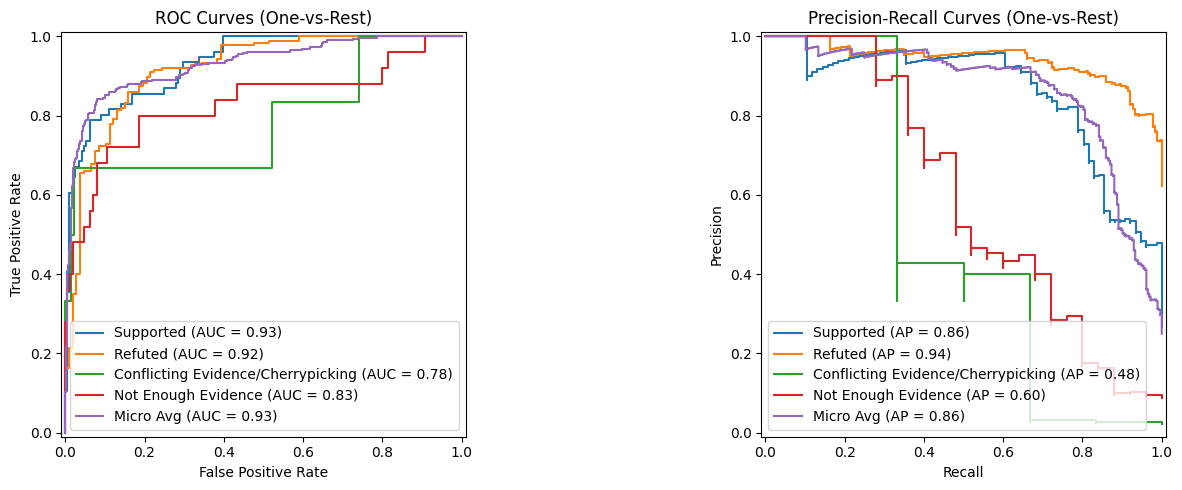

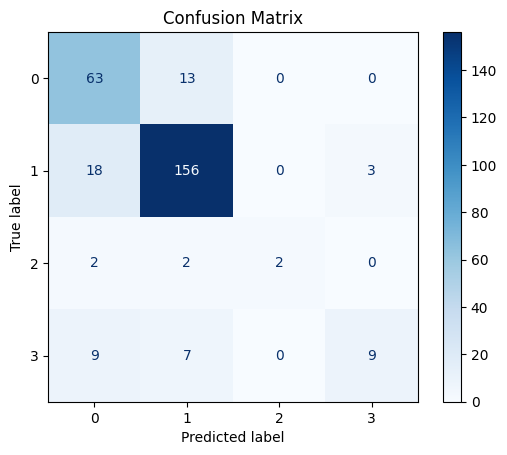

Macro ROC AUC: 0.87
Micro ROC AUC: 0.93
Macro Avg Precision: 0.75
Micro Avg Precision: 0.86


In [30]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

predictions = trainer.predict(eval_dataset)
pred_logits = predictions.predictions
true_labels = predictions.label_ids

probabilities = np.exp(pred_logits) / np.sum(np.exp(pred_logits), axis=1, keepdims=True)

n_classes = 4
y_true_bin = label_binarize(true_labels, classes=np.arange(n_classes))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probabilities[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], probabilities[:, i])
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], estimator_name=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})").plot(ax=ax1)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probabilities.ravel())
roc_auc["micro"] = roc_auc_score(y_true_bin, probabilities, multi_class="ovr", average="micro")
RocCurveDisplay(fpr=fpr["micro"], tpr=tpr["micro"], estimator_name=f"Micro Avg (AUC = {roc_auc['micro']:.2f})").plot(ax=ax1)

ax1.set_title("ROC Curves (One-vs-Rest)")
ax1.legend(loc="lower right")

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], probabilities[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], probabilities[:, i])
    PrecisionRecallDisplay(precision=precision[i], recall=recall[i], estimator_name=f"{class_names[i]} (AP = {average_precision[i]:.2f})").plot(ax=ax2)

precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), probabilities.ravel())
average_precision["micro"] = average_precision_score(y_true_bin, probabilities, average="micro")
PrecisionRecallDisplay(precision=precision["micro"], recall=recall["micro"], estimator_name=f"Micro Avg (AP = {average_precision['micro']:.2f})").plot(ax=ax2)

ax2.set_title("Precision-Recall Curves (One-vs-Rest)")
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

pred_labels = np.argmax(pred_logits, axis=1)
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

print(f"Macro ROC AUC: {roc_auc_score(true_labels, probabilities, multi_class='ovr', average='macro'):.2f}")
print(f"Micro ROC AUC: {roc_auc['micro']:.2f}")
print(f"Macro Avg Precision: {np.mean(list(average_precision.values())):.2f}")
print(f"Micro Avg Precision: {average_precision['micro']:.2f}")


In [31]:
def predict(claim, reality):
    inputs = tokenizer(
        claim,
        reality,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=1)
    return class_label.int2str(prediction.item())

In [32]:
test_claim = "Vaccines contain microchips"
test_reality = "No scientific evidence supports claims of microchips in vaccines"
print(predict(test_claim, test_reality))

Refuted
